In [ ]:
#\documentclass[fleqn]{article}
#\title{Beta-Binomial Model}
#\author{Jonathan Bryan}
#\date{March 12 2016}
#\usepackage[fleqn]{amsmath}
#\usepackage{amssymb}

# <center> Partial Least Squares (PLS) </center>
### <center> Jonathan Bryan and Carmen Dekmezian </center>


### Abstract

### Background
The paper we selected is titled “Partial Least Squares Regression: A Tutorial” by Geladi and Kowalski. It discusses partial least squares regression (PLSR), which is a method for decomposing values of predictors and response into more basic components and finding a robust linear relationship between the two components. PLSR was formulated by econometrician Herman Wold as a technique for "soft modelling", when the number of variables is high, the relationship between the variables is poorly understood and prediction is the primary goal. His son Svante Wold extended the use of PLSR to chemometrics to model high dimensional chemical data.

The nonexistence of a unique solution when the number of predictors is larger than the sample size of the data is a challenging problem in multiple linear regression, especially when multicollinearity and missing are also issues. Other methods that seek to reduce the dimensionality of the predictors, such as principal component analysis (PCR), allow for noise reduction and solve the collinearity problem. However, useful information for accurate prediction can be lost because PCR explains the useful directional information in the predictor space which may not be sufficiently linked to the space of new observed responses

PLSR produces X-scores, much like PCR, but also Y-scores that explain the given response space. These scores are generated by seeking important directions in the X-scores that are strongly associated with variation in the Y-scores and biased towards accurate predictions.

PLSR has several advantages over other methods. It is advantageous when the number of predictors is larger than the sample size and collinearity is high among the predictors. It is also a robust method regression because it reduces out of sample variance of residual errors and noise in the data in comparison to common multiple least squares regression algorithms. Additionally, it is beneficial when there are missing observations in the data. 

One disadvantage of PLSR is that the use of lower dimensional representations of the data and loadings of the model can make the interpretability of the important latent predictors difficult in some situations.

### Description of algorithm

PLS is a regression method used to overcome limitations discussed above for normal linear regressions (e.g., many collinear predictors, more predictors than samples, etc.) by mapping observed sets of observed variables to response variables by means of latent variables. Essentially the model assumes that the data is generated by an underlying model directed by a smaller number of latent variables in the data. 

First, two sets of latent variables are extracted from the data: $T$ (or x-scores) from the predictors, and $U$ (or y-scores) from the response variable. These latent vectors are determined through maximizing the covariance between different sets of variables. 

For the classic linear regression, we try to solve the equation, $ Y = X\beta + {\epsilon} $, where the ordinary least squares estimate for ${\beta}$ is identified as ${(X^T X)}^{-1} X^TY$. This estimate is obtained by minimizing the sum of squared residuals. However, models that have predictors with high collinearity or more predictors than observations can result in singularity of the matrix ${(X^T X)}$. As an alternative and way to fix this issue, we implement the PLS algorithm throught the following steps:

1) Start with vector $u$. If there is only one response variable, then $ u = y $, otherwise it is one of the columns of $Y$.

2) Calculate the weights for the predictors ($X$) :
$$ w = \frac{X^Tu}{u^Tu} $$

3) Determine $t$ ($X$ scores):

$$ t = Xw $$

4) Now perform similar calculations for $Y$. Calculate the weights for the response variable:
$$ c = \frac{X^Tt}{t^Tt} $$

5) Determine $u$ ($Y$ scores):
$$ u = \frac{Yc}{c^Tc} $$

6) If there is more than one response variable, then we test to determine whether the $t$ values have converged. If the change in $t$ from one iteration to the next, $ \frac{||t_{old} - t_{new}}{||t_{new}||} $, is not smaller than a threshold value, then we iterate through steps 2-5 until convergence is reached.

7) Deflate variables for next iteration.
$$ p = \frac{X^Tt}{t^Tt} $$
$$ X = X - tp^T $$
$$ Y = Y - tc^T $$

8) Iterate through components until they are not found to be predictive of $Y$.

In [1]:
# import packages
%matplotlib inline
import time
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn import cross_validation
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression as lin_reg
from sklearn.metrics import mean_squared_error
from math import sqrt

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load in ames home price train and test data
ames_train = pd.read_csv("ames_train.csv")
ames_test = pd.read_csv("ames_test.csv")

In [3]:
# merge both files first so there are the same number of categories created
ames_merged = pd.concat([ames_train, ames_test])
ames_merged = pd.get_dummies(ames_merged).drop(["price", "PID"], axis = 1).fillna(value=0)

In [4]:
# convert categorical variables to dummy variables
# create variables for train and test data separately, x for predictors, y for response

x_predictors_train = ames_merged[0:1500]
x_predictors_test = ames_merged[1500:2000]

y_train = ames_train.price
y_test = ames_test.price

### Algorithm: Partial Least Squares

In [5]:
import numpy as np
import pandas as pd

###Mean center and scale data##

#Load data
path = 'ames_train.csv'
data = pd.DataFrame.from_csv(path)
data = data[["price", "Lot.Area", "MS.SubClass", "Yr.Sold"]] #Take price, Lot.Area, MS.SubClass, and Yr.Sold as a dataframe
price_std = data["price"].std()

#Subtract the mean from each column
data = data - data.mean()

#Scale each column by the column standard deviation
data = data/data.std()

#Separate in to design matrix (X block) and response column vector (Y block)
X = data[["Lot.Area", "MS.SubClass", "Yr.Sold"]].as_matrix()
Y = data[["price"]].as_matrix()

In [6]:
#SEE PAGE 16

#Here we have one variable in the Y block so q = 1 
#and omit steps 5-8
q = 1

#For the X block, u = Y
u = Y #random y column from Y #Step 1
w_old = np.dot(u.T,X)/np.dot(u.T,u) #Step 2
w_new = w_old/np.linalg.norm(w_old) #Step 3
t = np.dot(X,w_new.T)/np.dot(w_new,w_new.T) #Step 4

#For the Y block can be omitted if Y only has one variable
q_old = np.dot(t.T,Y)/np.dot(t.T,t) #Step 5
q_new = q_old/np.linalg.norm(q_old) #Step 6
u = np.dot(Y,q_new.T)/np.dot(q_new,q_new.T) #Step 7

#Step 8: Check convergence

#Calculate the X loadings and rescale the scores and weights accordingly
p = np.dot(t.T,X)/np.dot(t.T,t) #Step 9
p_new = p.T/np.linalg.norm(p.T) #Step 10
t_new = t/np.linalg.norm(p.T) #Step 11
w_new = w_old/np.linalg.norm(p)  #Step 12

#Find the regression coefficient for b for th inner relation
b = np.dot(u.T,t_new)/np.dot(t.T,t) #Step 13
b

#Calculation of the residuals
E_h = X - np.dot(t_new,p_new.T)
#F_h = Y - b.dot(t_new).dot(q.T) #NOT WORKING
F_h = Y - b.dot(t_new.T).T.dot(q) #WORKS BUT IS THIS RIGHT?

RMSE = np.sqrt(sum((F_h)**2)/F_h.shape[0])
print(RMSE * price_std) # I believe this is the RMSE since the Y had to be scaled.

print(X.shape) #X matrix
print(t_new.shape) # t column vector
print(u.shape) # u column vector
print(Y.shape) #Y "matrix" but column vector because only 1 Y variable
print(p.shape) # p transpose row vector
print(b.shape) # b scalar
print(q_new.shape) # q transpose row vector
print(w_new.shape) # w transpose row vector

[ 69371.29722587]
(1500, 3)
(1500, 1)
(1500, 1)
(1500, 1)
(1, 3)
(1, 1)
(1, 1)
(1, 3)


### Applications to real data sets

In the paper we selected, the authors don’t include real-world examples with data that we can test on. Thus, we decided to test the algorithm on a publicly available dataset that we investigated for our predictive modeling class. This data contains information on residential properties in Ames, Iowa, with 79 variables that describe characteristics of each home and a variable indicating the home’s value.[ref: Decook]

We decided to use this dataset because it contains many correlated variables, some of which have very similar meanings. For example, the dataset includes the variables Garage.qual and Garage.cond, both of which can take on values of: Ex (excellent), Gd (good), TA (typical/average), Fa (fair), Po (Poor), or NA (no garage). Additionally, since there are so many different factor/categorical variables in the dataset, the total number of predictors becomes 288 when trying to estimate a coefficient for each level. Since these characteristics play into the strength of the PLS method, PLS method is beneficial 

With this data, we were trying to predict a home’s price based on its attributes. The limitations of the data, including the number of predictors and collinearity, suggest that the PLS method will be beneficial for predictions and accuracy.

After running the PLS method using the training data and performing cross-validations, we then tested our model on the test data. Our final model ended up giving us a root mean squared error of ____________.

### Comparative analysis with competing algorithms

With the Ames housing data, we decided to test our PLS results above with the standard OLS regression and the PCR method. In the OLS regression, we tried predicting price using all of the variables in the dataset. The model is as follows:
$$ y = X\beta + \epsilon $$
$$ price = \beta_0 + x_1\beta_1 + ... + x_p\beta_p + \epsilon $$ 
where we have $p$ predictors available in the data.

For the OLS model, $\beta$ is estimated by minimizing the sum of squared errors and can be express as ${(X^T X)}^{-1} X^TY$. All predictors are used in estimating the $\beta$ coefficients, unlike pcr and PLS which keeps only a subset of the features for prediction.

The PCR regression is similar to the PLS regression in that it selects a subset of features out of the larger number of predictors to include in the model.

### Simple Algorithm: OLS

In [7]:
# speed of algorithm
ols_start = timeit.default_timer()

# run ols on home price model
ols_reg = lin_reg().fit(x_predictors_train, y_train)
y_test_pred_ols = ols_reg.predict(x_predictors_test)
ols_rmse_test = sqrt(mean_squared_error(y_test, y_test_pred_ols))

ols_speed = timeit.default_timer() - ols_start

### Alternative Algorithm: PCR

In [8]:
# speed of pcr algorithm
pcr_start = timeit.default_timer()

# scale x train data
x_scaled_train = PCA().fit_transform(scale(x_predictors_train))
n = len(x_scaled_train)

# perform cross validation (10 k-fold)
cross_val_k_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=1)
pcr_rmse = []

# calculate rmse values for intercept (no predictors/components)
mean_sq_error = -1*cross_validation.cross_val_score(lin_reg(), np.ones((n,1)), y_train.ravel(), cv = cross_val_k_10, scoring = "neg_mean_squared_error").mean()
pcr_rmse.append(sqrt(mean_sq_error))

# calculate rmse values for varying numbers of predictors/components
for i in range(1, len(x_predictors_train.columns)):
    mean_sq_error = -1*cross_validation.cross_val_score(lin_reg(), x_scaled_train[:,:i], y_train.ravel(), cv = cross_val_k_10, scoring = "neg_mean_squared_error").mean()
    pcr_rmse.append(sqrt(mean_sq_error))

# find number of principal components with smallest rmse
n_pcr_comps = pcr_rmse.index(min(pcr_rmse))

# run regression using specific number of principal components
pcr_reg = lin_reg().fit(x_scaled_train[:,:n_pcr_comps], y_train)

# use regression above to predict on test data
x_scaled_test = PCA().fit_transform(scale(x_predictors_test))[:,:n_pcr_comps]
y_test_pred_pcr = pcr_reg.predict(x_scaled_test)
pcr_rmse_test = sqrt(mean_squared_error(y_test, y_test_pred_pcr))
    
pcr_speed = timeit.default_timer() - pcr_start

(20000, 200000)

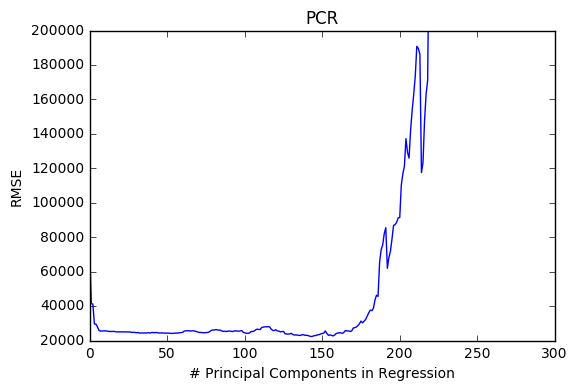

In [9]:
plt.plot(pcr_rmse)
plt.title("PCR")
plt.xlabel("# Principal Components in Regression")
plt.ylabel("RMSE")
plt.ylim(ymin = 20000, ymax = 200000)

In [10]:
# summary of all methods, accuracy and speed
diff_methods_summary = {'RMSE' : [1111., pcr_rmse_test, ols_rmse_test], 'Speed' : [1111, pcr_speed, ols_speed]}
pd.DataFrame(diff_methods_summary, index=['PLS', 'PCR', 'OLS'])

,RMSE,Speed
PLS,1.111000e+03,1111.000000
PCR,6.537511e+04,106.189511
OLS,2.524432e+08,0.238147


### Discussion/Conclusion



### References

used a lot of it in running pcr 
http://www.science.smith.edu/~jcrouser/SDS293/labs/lab11/Lab%2011%20-%20PCR%20and%20PLS%20Regression%20in%20Python.pdf